In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [2]:
import os
import numpy as np

# 数据文件
fname = os.path.join("/kaggle/input/jena-climate/jena_climate_2009_2016.csv")
# 读取数据
with open(fname) as f:
    data = f.read()

# 按行分割数据
lines = data.split("\n")
# 提取表头和数据, 每个数据以逗号分隔
header = lines[0].split(",")
# 去掉第一行（表头）
lines = lines[1:]
print(header)
print('记录总数：', len(lines))

# 温度变量赋初值0
temperature = np.zeros((len(lines),)) 
# 全部数据赋初值0，行数为记录数，列数为表头数减1(去掉时间列)
raw_data = np.zeros((len(lines), len(header) - 1))
# 逐行处理数据
for i, line in enumerate(lines):
    # 逗号分隔数据，去掉第一列（时间）
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1] # 第2列为温度数据
    raw_data[i, :] = values[:] # 全部数据（没有表头行、没有时间列）

print('温度数据：', temperature)
print('全部数据：', raw_data)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
记录总数： 420551
温度数据： [-8.02 -8.41 -8.51 ... -3.16 -4.23 -4.82]
全部数据： [[ 9.9652e+02 -8.0200e+00  2.6540e+02 ...  1.0300e+00  1.7500e+00
   1.5230e+02]
 [ 9.9657e+02 -8.4100e+00  2.6501e+02 ...  7.2000e-01  1.5000e+00
   1.3610e+02]
 [ 9.9653e+02 -8.5100e+00  2.6491e+02 ...  1.9000e-01  6.3000e-01
   1.7160e+02]
 ...
 [ 9.9982e+02 -3.1600e+00  2.7001e+02 ...  1.0800e+00  2.0000e+00
   2.1520e+02]
 [ 9.9981e+02 -4.2300e+00  2.6894e+02 ...  1.4900e+00  2.1600e+00
   2.2580e+02]
 [ 9.9982e+02 -4.8200e+00  2.6836e+02 ...  1.2300e+00  1.9600e+00
   1.8490e+02]]


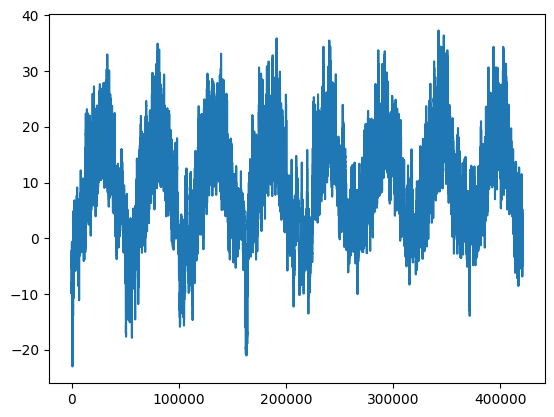

In [3]:
# 绘制8年全部温度数据
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

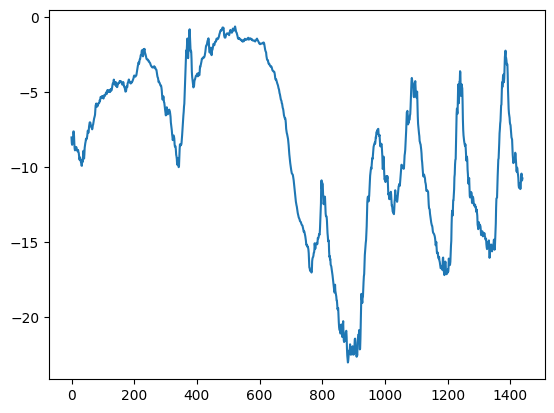

In [4]:
# 绘制前10天温度数据
ten_days = 6*24*10
plt.plot(range(ten_days), temperature[:ten_days])

In [5]:
# ======= 准备数据 =========
# 训练数据量，占50%，210225个
num_train_samples = int(0.5 * len(raw_data))
# 验证数据量，占25%，105112个
num_val_samples = int(0.25 * len(raw_data))
# 测试数据量，剩下的25%，105114个
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

# 训练数据平均值（有的数据值大，有的数据值小，归一化）
mean = raw_data[:num_train_samples].mean(axis=0) # 按列求平均值
# 所有数据减去平均值
raw_data -= mean
# 训练数据标准差
std = raw_data[:num_train_samples].std(axis=0)
# 所有数据除以标准差
raw_data /= std

num_train_samples: 210275
num_val_samples: 105137
num_test_samples: 105139


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 采样频率=6：每6个数据点采样(保留)一个数据点，即每小时一个数据点
sampling_rate = 6
# 序列长度，120个采样点，120小时（5天）
sequence_length = 120
# 延迟采样点数，预测24小时后的数据
delay_hours = 24
delay = sampling_rate * (sequence_length + delay_hours - 1)
# 批量大小
batch_size = 256

# 温度张量，torch.Size([419593])
temperature_tensor = torch.tensor(temperature[delay:], dtype=torch.float32)
# 数据张量，torch.Size([419593, 14])
raw_data_tensor = torch.tensor(raw_data[:-delay], dtype=torch.float32)
print("temperature_tensor shape:", temperature_tensor.shape)
print("raw_data_tensor shape:", raw_data_tensor.shape)

# 定义创建数据集函数
def create_dataset(data, targets, sampling_rate, sequence_length):
    sequences = []
    labels = []
    for i in range(0, len(data) - sequence_length * sampling_rate + 1):
        # 每6个数据点采样(保留)一个数据点，即每小时一个数据点
        sequences.append(data[i : i + sequence_length * sampling_rate : sampling_rate])
        labels.append(targets[i])
    
    # 返回 数据集 + 标签
    return torch.stack(sequences), torch.tensor(labels)

# 训练数据集+标签
train_data, train_labels = create_dataset(raw_data_tensor[:num_train_samples], 
                                        temperature_tensor[:num_train_samples], 
                                        sampling_rate, 
                                        sequence_length )
# 验证数据集+标签
val_data, val_labels = create_dataset(
    raw_data_tensor[num_train_samples : num_train_samples + num_val_samples],
    temperature_tensor[num_train_samples : num_train_samples + num_val_samples],
    sampling_rate,    sequence_length )
# 测试数据集+标签
test_data, test_labels = create_dataset(
    raw_data_tensor[num_train_samples + num_val_samples :],
    temperature_tensor[num_train_samples + num_val_samples :],
    sampling_rate,    sequence_length )

# 数据集+标签 转换为 张量数据集
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

# 加载数据
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# 显示数据
for samples, targets in train_loader:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    print("samples:", samples[0])
    print("targets:", targets[0])
    break
print("train_loader:", len(train_loader))

temperature_tensor shape: torch.Size([419693])
raw_data_tensor shape: torch.Size([419693, 14])
samples shape: torch.Size([256, 120, 14])
targets shape: torch.Size([256])
samples: tensor([[-0.8653, -2.2925, -2.2127,  ..., -0.3716, -0.4738,  0.8185],
        [-0.8442, -2.2629, -2.1845,  ..., -0.4499, -0.7579,  0.6833],
        [-0.8230, -2.2321, -2.1552,  ..., -0.8216, -0.9646,  0.3537],
        ...,
        [-1.2875, -1.3997, -1.2922,  ..., -0.1434, -0.2241, -1.8077],
        [-1.2593, -1.3849, -1.2798,  ..., -0.4760, -0.4824, -1.6708],
        [-1.3063, -1.4111, -1.3023,  ...,  0.6651,  0.0471, -1.5994]])
targets: tensor(-2.3300)
train_loader: 819


In [7]:
# ======= 方法1：基于常识的预测方法 =========
# 根据每天气温变化的周期性，预测未来24小时的温度等于当前时刻的温度
def evaluate_naive_method(dataloader):
    total_abs_err = 0
    samples_seen = 0
    for samples, targets in dataloader:
        # 将归一化的数据 转换为 原始数据. 
        # samples[:, -1, 1]中-1表示最后一个时间步，1表示温度数据
        preds = samples[:, -1, 1] * std[1] + mean[1]
        # 计算绝对误差
        abs_arr = np.abs(preds - targets).numpy()
        # 总误差
        total_abs_err += np.sum(abs_arr)
        # 样本数，samples.shape[0]为批量大小
        samples_seen += samples.shape[0]
    print("total_abs_err:", total_abs_err, "samples_seen:", samples_seen)
    return total_abs_err / samples_seen

# 验证数据集上的MAE
print(f"验证数据集上的平均误差: {evaluate_naive_method(val_loader):.2f}°C")
# 测试数据集上的MAE
print(f"测试数据集上的平均误差: {evaluate_naive_method(test_loader):.2f}°C")

total_abs_err: 255045.2197265625 samples_seen: 104418
验证数据集上的平均误差: 2.44°C
total_abs_err: 271408.73028564453 samples_seen: 103562
测试数据集上的平均误差: 2.62°C


In [10]:
# 定义训练模型函数
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

# 训练模型
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, best_model_path):
    train_mae_arr, val_mae_arr, train_loss_arr, val_loss_arr = [], [], [], []
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss, train_mae = 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_mae += F.l1_loss(outputs, targets.unsqueeze(1)).item()

        train_loss_arr.append(train_loss / len(train_loader))
        train_mae_arr.append(train_mae / len(train_loader))

        val_loss, val_mae = test_model(model, val_loader, criterion)
        val_loss_arr.append(val_loss)
        val_mae_arr.append(val_mae)

        if epoch == 0 or val_mae < min(val_mae_arr):
            torch.save(model.state_dict(), best_model_path)

        print(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_arr[-1]:.4f}, Train MAE: {train_mae_arr[-1]:.4f}, Val Loss: {val_loss_arr[-1]:.4f}, Val MAE: {val_mae_arr[-1]:.4f}"
        )

    print("Best Val MAE:", min(val_mae_arr))
    return train_loss_arr, train_mae_arr, val_loss_arr, val_mae_arr

# 测试模型
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss, test_mae = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            test_loss += loss.item()
            test_mae += torch.mean(torch.abs(outputs - targets.unsqueeze(1))).item()
    return test_loss / len(test_loader), test_mae / len(test_loader)

# 绘制损失和MAE曲线
def plot_loss(train_loss_arr, val_loss_arr, train_mae_arr, val_mae_arr):
    fig, ax1 = plt.subplots()

    color = "tab:red"
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("Loss", color=color)
    ax1.plot(train_loss_arr, label="Train Loss", color=color)
    ax1.plot(val_loss_arr, label="Val Loss", color=color, linestyle="dashed")
    ax1.tick_params(axis="y", labelcolor=color)
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    color = "tab:blue"
    ax2.set_ylabel("MAE", color=color)
    ax2.plot(train_mae_arr, label="Train MAE", color=color)
    ax2.plot(val_mae_arr, label="Val MAE", color=color, linestyle="dashed")
    ax2.tick_params(axis="y", labelcolor=color)
    ax2.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

# 定义显示5组真实值、预测值曲线的函数
def plot_results(model, test_loader):
    model.eval()
    with torch.no_grad():
        inputs, targets = next(iter(test_loader))
        outputs = model(inputs.to(device)).cpu()
        inputs = inputs * std[1] + mean[1]
        targets = targets
        outputs = outputs
        for i in range(5):
            plt.figure()
            plt.plot(range(sequence_length), inputs[i, :, 1], label="History")
            plt.scatter(sequence_length + delay_hours - 1, targets[i], marker="x", color="red", label="True Future")
            plt.scatter(sequence_length + delay_hours - 1, outputs[i], marker="o", color="blue", label="Predicted Future")
            plt.legend()
            plt.show()

 10%|█         | 1/10 [00:07<01:05,  7.33s/it]

Epoch 1/10, Train Loss: 17.5320, Train MAE: 3.1680, Val Loss: 15.7616, Val MAE: 3.2221


 20%|██        | 2/10 [00:13<00:55,  6.90s/it]

Epoch 2/10, Train Loss: 11.5852, Train MAE: 2.6686, Val Loss: 9.9978, Val MAE: 2.4762


 30%|███       | 3/10 [00:20<00:46,  6.65s/it]

Epoch 3/10, Train Loss: 10.9870, Train MAE: 2.5937, Val Loss: 9.1900, Val MAE: 2.3653


 40%|████      | 4/10 [00:26<00:39,  6.58s/it]

Epoch 4/10, Train Loss: 10.6757, Train MAE: 2.5540, Val Loss: 9.3308, Val MAE: 2.3823


 50%|█████     | 5/10 [00:33<00:32,  6.57s/it]

Epoch 5/10, Train Loss: 10.4385, Train MAE: 2.5253, Val Loss: 9.2211, Val MAE: 2.3657


 60%|██████    | 6/10 [00:40<00:26,  6.63s/it]

Epoch 6/10, Train Loss: 10.2309, Train MAE: 2.5005, Val Loss: 9.7526, Val MAE: 2.4364


 70%|███████   | 7/10 [00:46<00:19,  6.60s/it]

Epoch 7/10, Train Loss: 10.1256, Train MAE: 2.4853, Val Loss: 9.1974, Val MAE: 2.3605


 80%|████████  | 8/10 [00:53<00:13,  6.57s/it]

Epoch 8/10, Train Loss: 10.0500, Train MAE: 2.4760, Val Loss: 9.1243, Val MAE: 2.3483


 90%|█████████ | 9/10 [00:59<00:06,  6.54s/it]

Epoch 9/10, Train Loss: 10.0108, Train MAE: 2.4701, Val Loss: 9.0664, Val MAE: 2.3431


100%|██████████| 10/10 [01:06<00:00,  6.61s/it]

Epoch 10/10, Train Loss: 9.9690, Train MAE: 2.4635, Val Loss: 9.3762, Val MAE: 2.3857
Best Val MAE: 2.3430894563595452


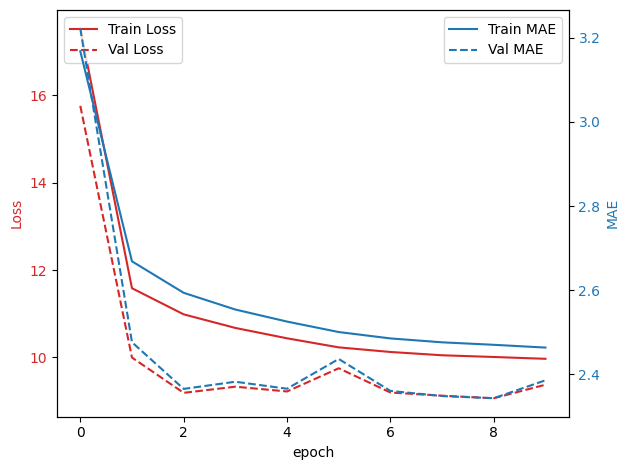

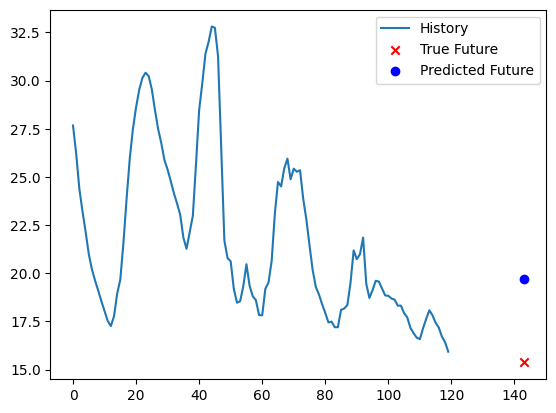

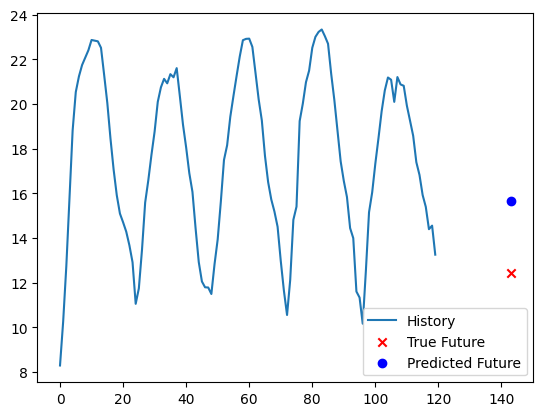

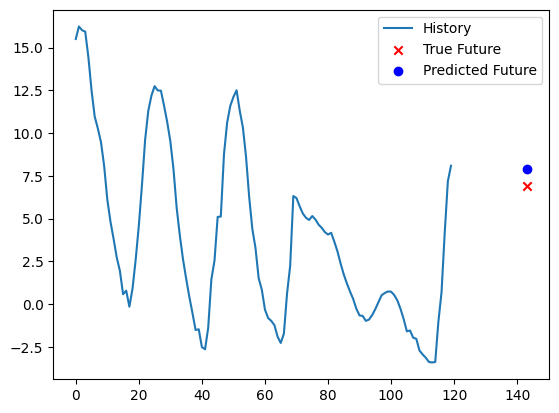

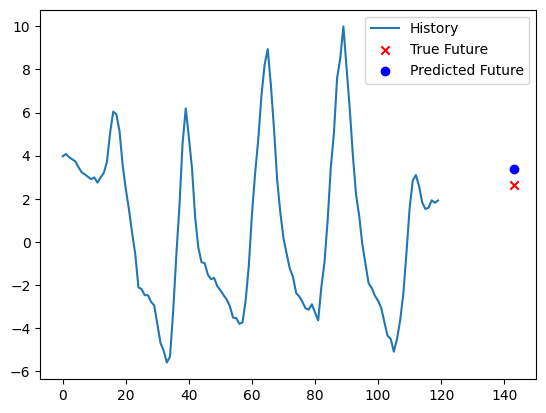

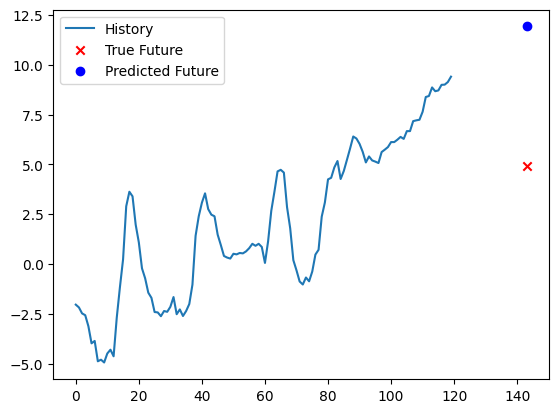

In [11]:
# ======= 方法4：用RNN预测 =========
import torch
import torch.nn as nn
import torch.optim as optim

# 定义RNN模型
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, nonlinearity='relu',
                          batch_first=True  ) # batch_size在第1维，即[batch, seq, feature]
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # hn：最后一个时间步的隐藏状态
        _, hn = self.rnn(x)
        # 仅返回最后一层的隐藏状态！
        out = self.fc(hn[-1])
        return out

# 超参数
input_size = raw_data.shape[-1] # 特征数=14
hidden_size = 16
output_size = 1

# 创建模型
model = RNNModel(input_size, hidden_size, output_size)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
best_model_path = "rnn_model.pth"

# 训练模型
train_loss_arr, train_mae_arr, val_loss_arr, val_mae_arr = train_model(
    model, train_loader, val_loader, criterion, optimizer, 10, best_model_path )

# 绘制曲线
plot_loss(train_loss_arr, val_loss_arr, train_mae_arr, val_mae_arr)
model.load_state_dict(torch.load(best_model_path, weights_only=True))
plot_results(model, test_loader)

In [ ]:
# 显示模型结构
from torchinfo import summary
summary(model, input_size=(batch_size, sequence_length, raw_data.shape[-1]))

 10%|█         | 1/10 [00:07<01:10,  7.87s/it]

Epoch 1/10, Train Loss: 42.1035, Train MAE: 4.7344, Val Loss: 15.6034, Val MAE: 2.9088


 20%|██        | 2/10 [00:15<01:02,  7.83s/it]

Epoch 2/10, Train Loss: 11.2064, Train MAE: 2.5591, Val Loss: 9.8608, Val MAE: 2.4334


 30%|███       | 3/10 [00:23<00:55,  7.86s/it]

Epoch 3/10, Train Loss: 8.7997, Train MAE: 2.3124, Val Loss: 9.8490, Val MAE: 2.4542


 40%|████      | 4/10 [00:32<00:48,  8.09s/it]

Epoch 4/10, Train Loss: 7.8960, Train MAE: 2.1997, Val Loss: 9.6185, Val MAE: 2.4302


 50%|█████     | 5/10 [00:39<00:40,  8.03s/it]

Epoch 5/10, Train Loss: 7.1534, Train MAE: 2.0960, Val Loss: 10.3350, Val MAE: 2.5113


 60%|██████    | 6/10 [00:47<00:32,  8.01s/it]

Epoch 6/10, Train Loss: 6.6304, Train MAE: 2.0163, Val Loss: 10.6763, Val MAE: 2.5596


 70%|███████   | 7/10 [00:55<00:23,  7.97s/it]

Epoch 7/10, Train Loss: 6.0564, Train MAE: 1.9258, Val Loss: 11.0495, Val MAE: 2.5834


 80%|████████  | 8/10 [01:03<00:15,  7.98s/it]

Epoch 8/10, Train Loss: 5.6055, Train MAE: 1.8508, Val Loss: 11.0223, Val MAE: 2.5898


 90%|█████████ | 9/10 [01:11<00:08,  8.05s/it]

Epoch 9/10, Train Loss: 5.2010, Train MAE: 1.7835, Val Loss: 11.8669, Val MAE: 2.6856


100%|██████████| 10/10 [01:19<00:00,  7.98s/it]

Epoch 10/10, Train Loss: 4.9172, Train MAE: 1.7326, Val Loss: 11.8728, Val MAE: 2.6668
Best Val MAE: 2.430171738652622


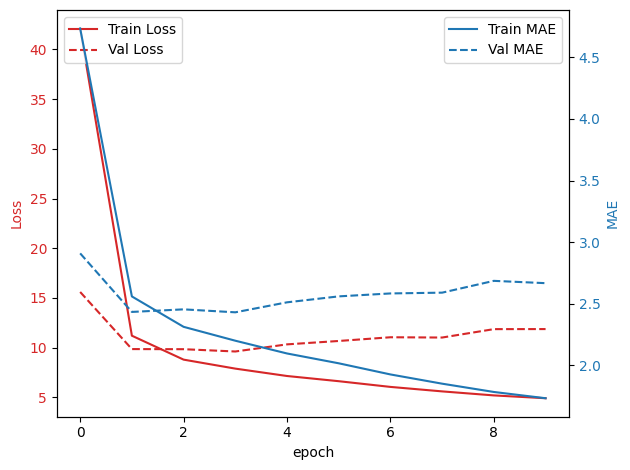

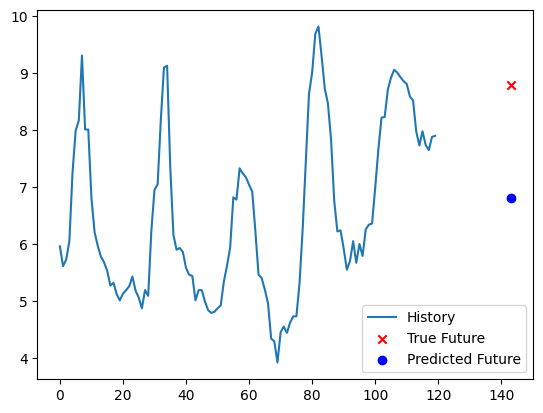

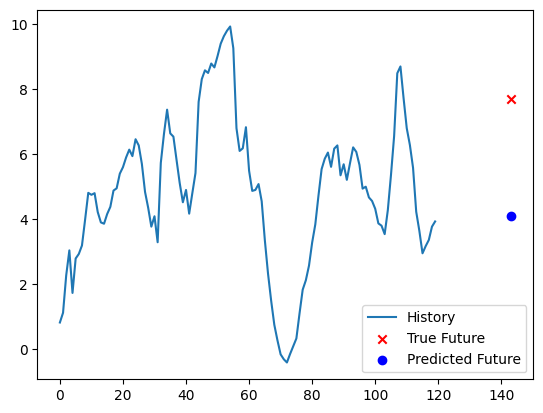

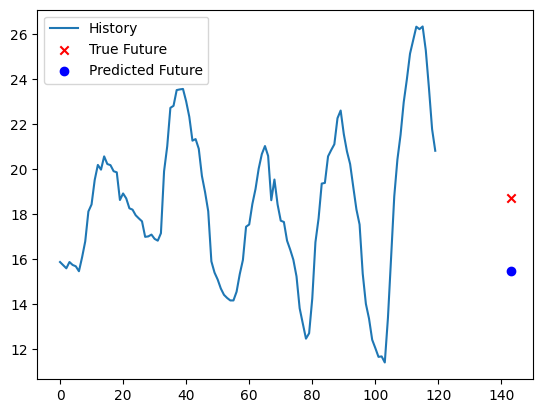

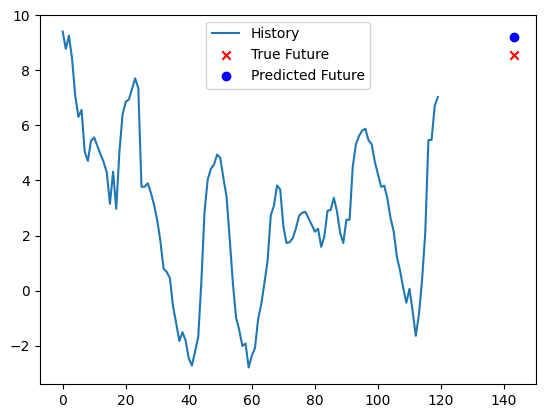

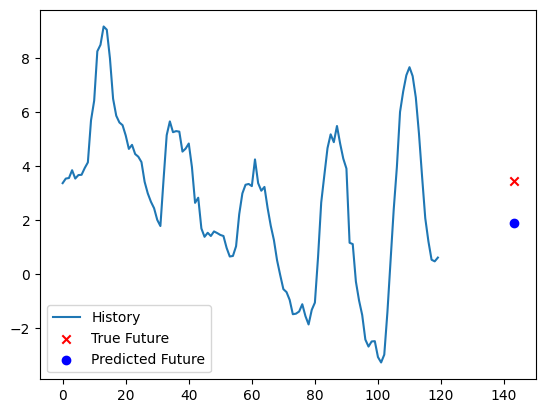

In [37]:
# ======= 方法9：用双层LSTM预测 =========
import torch
import torch.nn as nn
import torch.optim as optim

# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        # 只要最后一层的隐藏状态
        out = self.fc(hn[-1])
        return out

# 超参数
input_size = raw_data.shape[-1] # 特征数=14
hidden_size = 16
num_layers = 4    # 双层LSTM
output_size = 1

# 模型
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
best_model_path = "lstm2_model.pth"

# 训练模型
train_loss_arr, train_mae_arr, val_loss_arr, val_mae_arr = train_model(
    model, train_loader, val_loader, criterion, optimizer, 10, best_model_path)
# 绘图
plot_loss(train_loss_arr, val_loss_arr, train_mae_arr, val_mae_arr)
model.load_state_dict(torch.load(best_model_path, weights_only=True))
plot_results(model, test_loader)